In [282]:
import pandas as pd
import numpy
import json
import dateparser
import datetime
import seaborn as sns
import matplotlib as mpl
sns.set_style('white', {'legend.frameon':True})
mpl.rcParams['figure.figsize'] = 25, 10

In [283]:

def vek(vstup):
    try:
        vystup = int(abs(float(vstup)))/1000 if abs(float(vstup)) > 1000 else int(abs(float(vstup)))
        if vystup is not int(vystup):
            vystup *= 10
        if vystup % 100 is 0:
            vystup /= 100
        return vystup
    except ValueError:
        return numpy.nan


def datum(vstup):
    formaty = ['%Y-%m-%d', '%Y/%m/%d', '%y-%m-%d', '%d/%m/%Y']
    vstup = vstup[:10].strip()
    if not len(vstup):
        return numpy.nan
    vystup = dateparser.parse(vstup, formaty)
    if vystup is None:
        raise Exception('Nenaznamy format datumu:' + vstup)
    if vystup.year > 2018:
        vystup = vystup - datetime.timedelta(36500)     
    if vystup.year < 1900:
        vystup = datetime.datetime(1900 + vystup.year % 100, vystup.month, vystup.day)
    return vystup


konvertovace = {
    'age' : vek,
    'date_of_birth': datum
}

personalne = pd.read_csv("data/personal_train.csv", na_values='?', index_col=0, converters=konvertovace, )

In [284]:
# personalne[personalne['date_of_birth'].year + personalne['age'] < 2017]
# def vypisi(row):
#     if not pd.isna(row['date_of_birth']) and (row['date_of_birth'].year + row['age'] < 2017 or row['date_of_birth'].year + row['age'] > 2018):
#         print(row)
# 
# personalne.apply(vypisi, axis=1)

In [285]:
personalne[personalne['age'] > 100]

,name,address,age,sex,date_of_birth
2131,Susana Marshall,"96194 Lindsay Viaduct\nMillertown, WY 92869",455.0,F,1963-05-03


Nacitane personalne data, s opravenym vekom a datumom narodenia.

In [286]:
bulo = lambda vstup: numpy.nan if pd.isna(vstup) or len(str(vstup).strip()) is 0 else str(vstup).strip().lower().split('.')[0][0] == 't'
classa = lambda vstup: vstup.lower().split('.|')[0]


def js(vstup):
    try:
        return str(vstup).replace("'", '"')
    except json.JSONDecodeError:
        pass

konvertovace = {
    "FTI measured": bulo,
    "tumor": bulo,
    "lithium": bulo,
    "thyroid surgery": bulo,
    "I131 treatment": bulo,
    "goitre": bulo,
    "hypopituitary": bulo,
    "query on thyroxine": bulo,
    "T3 measured": bulo,
    "TBG measured": bulo,
    "pregnant": bulo,
    "class": classa,
    "medical_info": js
}
other = pd.read_csv("data/other_train.csv", na_values=['?', '??', ' ?'], index_col=0, true_values=['t'],
                    false_values=['f'],
                    converters=konvertovace)
other = other.drop(columns=['TBG'])


Nacitane ostatne udaje s opravenymi boolovskymi hodnotami a vyhodenym prazdnym stlpcom TBG

In [287]:
def rozober_json(vstup):
    try:
        return pd.Series(json.loads(vstup))
    except json.JSONDecodeError:
        return pd.Series(json.loads('{}'))
other = other.join(other['medical_info'].apply(rozober_json))
other = other.drop(columns='medical_info')

Rozoberanie jsonu v medical_info stlpci na jednotlive stlpce

In [288]:
for stlpec in ['TSH measured', 'query hyperthyroid', 'TT4 measured', 'on antithyroid medication', 'sick', 'T4U measured', 'psych', 'query hypothyroid']:
    other[stlpec] = other[stlpec].apply(bulo)

other = other.replace('?', numpy.nan)

Oprava pridanych boolovskych stlpcov a nahradenie ? za NaN

In [289]:
vsetko = other.merge(personalne, on=('name', 'address'))
vsetko = vsetko.replace(to_replace=[None], value=numpy.nan)

Spojenie suborov a nahradenie None za NaN

In [290]:
def agreguj(vstup):
    vstup = vstup.reset_index()
    for hodnota in vstup.values:
        if not pd.isna(hodnota[1]) and str(hodnota[1]).strip() != '':
            return hodnota[1]
    return numpy.nan

In [291]:
vsetko = vsetko.groupby(['name', 'address']).aggregate(agreguj).reset_index()

Spojenie rovnakych riadkov. Momentalne berieme prvu neprazdnu hodnotu. V pripade ze by bolo neprazdnych hodnot viac, dal by sa pouzit priemer pre numericke atributy a modus pre kategoricke, pripadne najcastejsia hodnota v celom datasete ak by pocet vyskytov bol rovnaky.

In [292]:
vsetko.FTI = pd.to_numeric(vsetko.FTI)

In [293]:
vsetko = vsetko[vsetko['class']!='']

Odstranenie riadkov s prazdnou hodnotou class - tieto riadky by nam pri trenovani nepomohli

In [294]:
nenumericke = vsetko.select_dtypes(exclude=numpy.number).columns
modusy = {}
for stlpec in nenumericke:
    modusy[stlpec] = vsetko[stlpec].mode()
modusove = vsetko.replace(numpy.nan, value=modusy)


Doplnenie kategorickych atributov najcastejsou hodnotou

In [295]:
numericke = vsetko.select_dtypes(include=numpy.number).columns
mediany = {}
for stlpec in numericke:
    mediany[stlpec] = vsetko[stlpec].median()
medianove = vsetko.replace(numpy.nan, value=mediany)

Doplnenie chybajucich hodnot numerickych atributov medianom

In [296]:
medianove.to_csv(path_or_buf='data/opravene_spojene_medianom.csv')

In [297]:
def priemeraj(s): #s ako nazov stlpca pochopitelne...
    priemery = {}
    for hodnota in vsetko[s].unique():
        priemery[hodnota] = {}
        for stlpec in numericke:
            priemery[hodnota][stlpec] = vsetko[vsetko[s]==hodnota][stlpec].mean()
    priemerove = []
    for stlpec in numericke:
        for hodnota in vsetko[s].unique():
            priemerove.append(vsetko[vsetko[s]==hodnota].replace(numpy.nan, value=priemery[hodnota]))
    return pd.concat(priemerove)


In [298]:
priemerove = priemeraj('occupation')

Doplnenie chybajucich numerickych atributov pomocou linearnej regresie

In [299]:
priemerove.to_csv(path_or_buf='data/opravene_spojene_priemerove.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e7ecfbb00>,
      dtype=object)

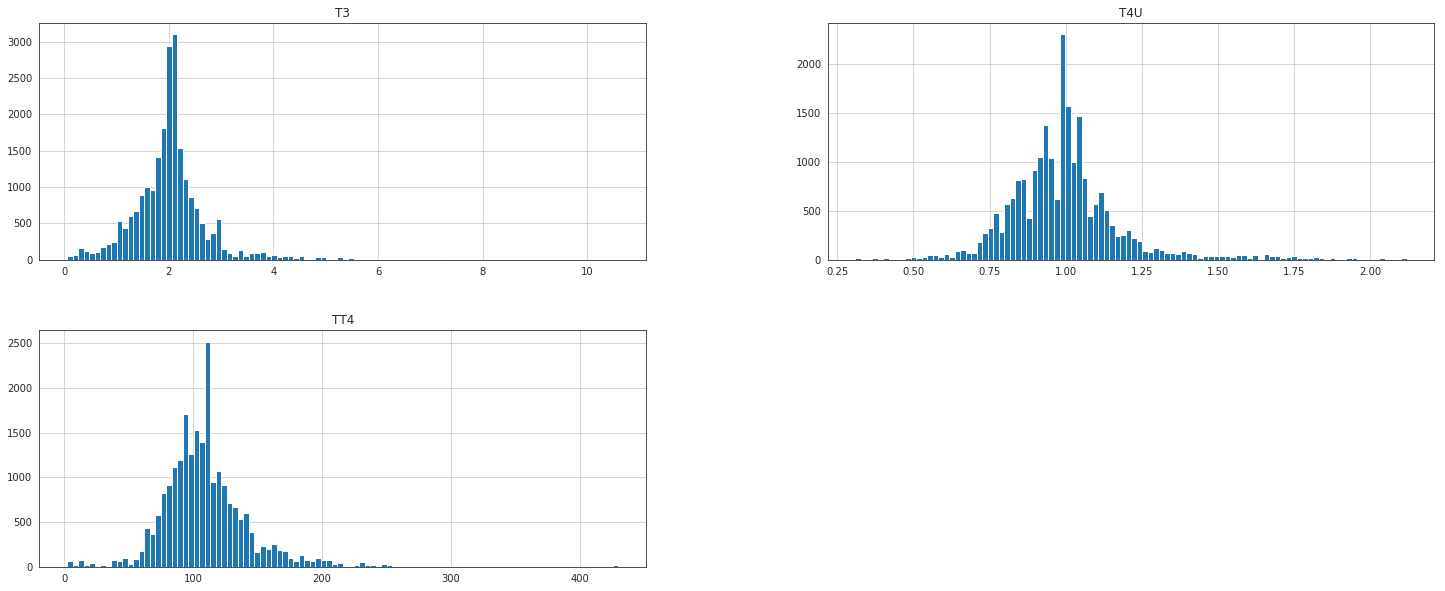

In [300]:
priemerove.hist(bins=100, column=["T4U", "TT4", "T3"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e7aa1a3c8>,
      dtype=object)

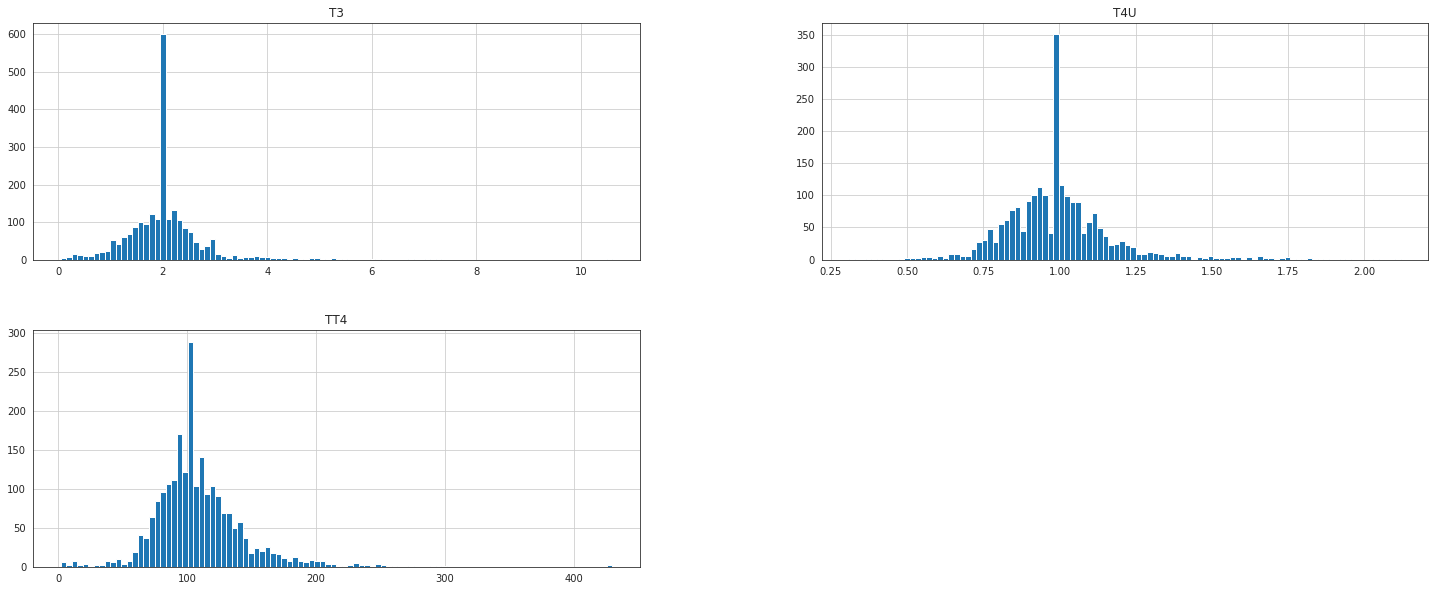

In [301]:
medianove.hist(bins=100, column=["T4U", "TT4", "T3"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e7a363358>,
      dtype=object)

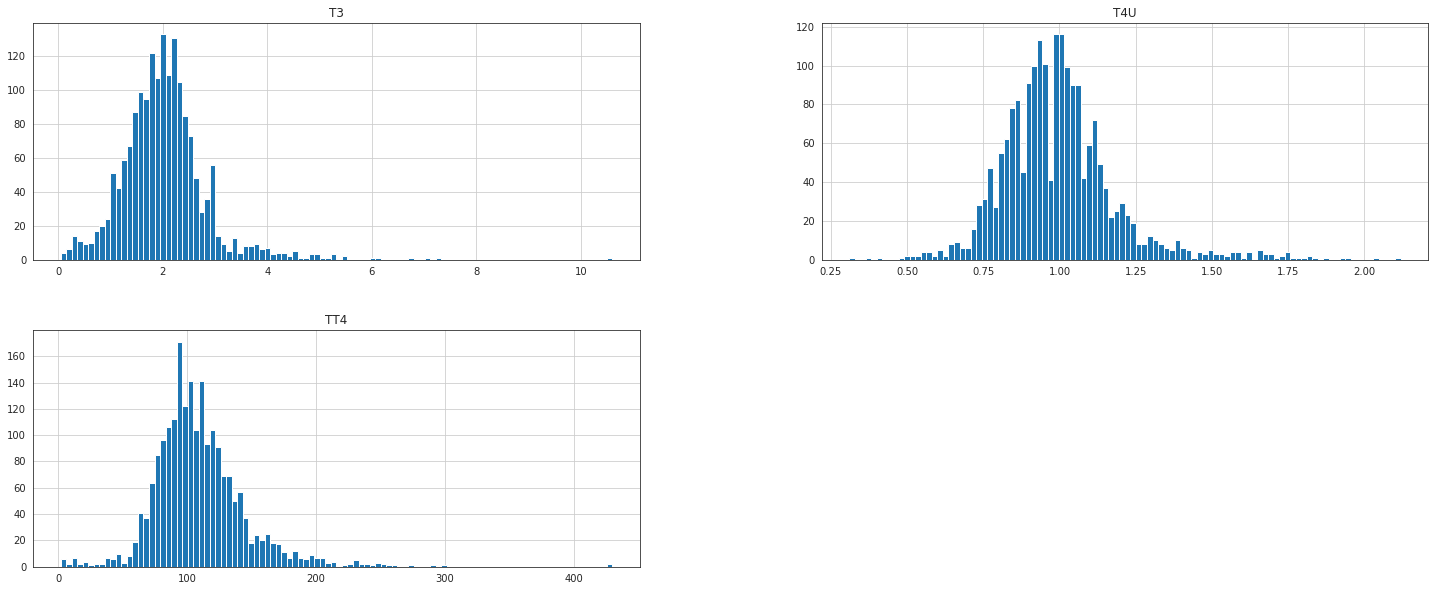

In [302]:
vsetko.hist(bins=100, column=["T4U", "TT4", "T3"])

In [303]:
vsetko.equals(linearne)

False